In [1]:
import os
import numpy as np
import tensorflow as tf
import skimage as sk
import matplotlib.pyplot as plt
from tqdm import tqdm

import models

PATH = '../data/landmarks/'

IMAGE_SIZE = (128,128,3)

# Limite size of input for testing
TEST_LIMIT = 1000

SPLIT = 0.8
BATCH_SIZE = 32
EPOCHS = 20
STEPS_PER_EPOCH = 40

In [3]:
# Retrieve the raw images
resized_path = PATH + 'resized/'
filenames = os.listdir(resized_path)

## Sort the filenames in the proper order
filename_int = np.sort([int(s[:-4]) for s in filenames])

filenames = np.array([resized_path + str(i) + '.jpg' for i in filename_int])

# Retrieve the masks
masks_path = PATH + 'resized_masks/'
f_masks = os.listdir(masks_path)

## Sort the filenames in the proper order
f_masks_int = np.sort([int(s[:-4]) for s in f_masks])

f_masks = np.array([resized_path + str(i) + '.jpg' for i in f_masks_int])

# Retrieve the landmarks
labels = np.load(PATH + 'resized_labels.npy')

# Reshape the outputs
print(labels.shape)
print(f_masks.shape)
print(filenames.shape)
assert len(f_masks)==len(labels)
assert len(filenames)==len(labels)

if TEST_LIMIT>len(labels):
    TEST_LIMIT = len(labels)


w,h,c = IMAGE_SIZE
images = np.empty((0,w,h,c))

masks = np.empty((0,w,h,1))

print("Loading images...")
labels = labels[:TEST_LIMIT]
labels = np.reshape(labels,(TEST_LIMIT,14))
labels = labels[:,:10]

for i in tqdm(range(TEST_LIMIT)):
    image = sk.io.imread(filenames[i])
    image_resized = sk.transform.resize(image, IMAGE_SIZE)
    images = np.vstack((images,np.expand_dims(image_resized,0)))

    mask = sk.io.imread(f_masks[i])

    mask_resized = sk.transform.resize(mask, (w,h,1))
    masks = np.vstack((masks,np.expand_dims(mask_resized,0)))



train_split = int(SPLIT*len(labels))

images_train = images[:train_split]
images_valid = images[train_split:]

masks_train = masks[:train_split]
masks_valid = masks[train_split:]

labels_train = labels[:train_split]
labels_valid = labels[train_split:]

(658, 7, 2)
(658,)
(658,)
Loading images...


  0%|                                                                                          | 0/658 [00:00<?, ?it/s]c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|████████████████████████████████████████████████████████████████████████████████| 658/658 [01:44<00:00,  6.30it/s]


In [15]:
def TriNet(ratio=4, input_shape=(128,128,3)):
    """
    Arguments:
     -ratio: ratio of channel reduction in SE module
     -imput_shape: input image shape
    """
    
    def CBA_layer(x, filters, size=3, depth=2):
        
        for _ in range(depth):
            x = tf.keras.layers.Conv2D(filters, (size, size), padding='same') (x)
            x = tf.keras.layers.BatchNormalization()(x)
            x = tf.keras.layers.Activation('relu')(x)
            
        return x
    
    def Res_layer(x, num_split, filters):
        '''
        ResNet-like layer
        '''
        
        # Spliting the branches and changing the size of the convolution
        splitted_branches = list()
        
        for i in range(num_split):
            if i+1 < 6:
                size = i+1 
            else:
                size = 3
            branch = CBA_layer(x, filters, size)
            splitted_branches.append(branch)
        
        x = tf.keras.layers.concatenate(splitted_branches)
        
        x = tf.keras.layers.Conv2D(filters, (3, 3), padding='same') (x)
        x = tf.keras.layers.BatchNormalization()(x)
        
        return x
    
    def SE_layer(x):
        '''
        SENet-like layer
        '''
        out_dim = int(np.shape(x)[-1])
        squeeze = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        excitation = tf.keras.layers.Dense(units=out_dim // ratio)(squeeze)
        excitation = tf.keras.layers.Activation('relu')(excitation)
        excitation = tf.keras.layers.Dense(units=out_dim)(excitation)
        excitation = tf.keras.layers.Activation('sigmoid')(excitation)
        excitation = tf.keras.layers.Reshape((1,1,out_dim))(excitation)
        
        scale = tf.keras.layers.multiply([x,excitation])
        
        return scale
    
    def RSE_layer(x, num_split, filters):
        r = Res_layer(x, num_split, filters)
        s = SE_layer(r)
        c = tf.keras.layers.concatenate([x,s])
        return tf.keras.layers.Activation('relu')(c)
    

    inputs = tf.keras.Input(input_shape)

    s = tf.keras.layers.Lambda(lambda x: x / 255) (inputs)
    
    #Down 1
    r1 = RSE_layer(s, 2, 8)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r1)
    
    #Down 2
    r2 = RSE_layer(x, 4, 16)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r2)
    
    #Down 3
    r3 = RSE_layer(x, 4, 32)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r3)
    
    #Down 4
    r4 = RSE_layer(x, 6, 64)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r4)
    
    #Down 5
    r5 = RSE_layer(x, 6, 128)
    x = tf.keras.layers.MaxPooling2D((2, 2)) (r5)
    
    #Middle
    x = RSE_layer(x, 4, 256)

    # First branch: landmarks detection
    y = CBA_layer(x, 512)
    y = tf.keras.layers.GlobalAveragePooling2D()(y)
    y = tf.keras.layers.Flatten()(y)
    y = tf.keras.layers.Dense(10)(y)
    landmarks_output = tf.keras.layers.Lambda(lambda x: x * 255, name='landmarks_output')(y)
    
    # Second branch: mask generation
    #Up 1
    x = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r5])
    x = RSE_layer(x, 6, 128)
    
    #Up 2
    x = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r4])
    x = RSE_layer(x, 6, 64)
    
    #Up 3
    x = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r3])
    x = RSE_layer(x, 4, 32)
    
    #Up 4
    x = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r2])
    x = RSE_layer(x, 4, 16)
    
    #Up 5
    x = tf.keras.layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (x)
    x = tf.keras.layers.concatenate([x,r1])
    x = RSE_layer(x, 2, 8)
    
    mask_output = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid', name='mask_output') (x)
    
    return tf.keras.Model(inputs, [landmarks_output, mask_output])

In [16]:
# layers = [10, 16, 32, 64, 128]
# model = models.MultiTaskResNet(layers, 14, IMAGE_SIZE)
model = TriNet()
print(model.summary())

losses = {
    "mask_output": "binary_crossentropy",
    "landmarks_output": "mse"
}

model.compile(optimizer=tf.train.AdamOptimizer(),
              loss=losses,
              metrics=['accuracy']) 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 128, 128, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_568 (Conv2D)             (None, 128, 128, 8)  32          lambda_5[0][0]                   
__________________________________________________________________________________________________
conv2d_570 (Conv2D)             (None, 128, 128, 8)  104         lambda_5[0][0]                   
__________________________________________________________________________________________________
batch_norm

activation_674 (Activation)     (None, 64, 64, 16)   0           batch_normalization_578[0][0]    
__________________________________________________________________________________________________
conv2d_574 (Conv2D)             (None, 64, 64, 16)   272         activation_668[0][0]             
__________________________________________________________________________________________________
conv2d_576 (Conv2D)             (None, 64, 64, 16)   1040        activation_670[0][0]             
__________________________________________________________________________________________________
conv2d_578 (Conv2D)             (None, 64, 64, 16)   2320        activation_672[0][0]             
__________________________________________________________________________________________________
conv2d_580 (Conv2D)             (None, 64, 64, 16)   4112        activation_674[0][0]             
__________________________________________________________________________________________________
batch_norm

__________________________________________________________________________________________________
conv2d_585 (Conv2D)             (None, 32, 32, 32)   4128        activation_681[0][0]             
__________________________________________________________________________________________________
conv2d_587 (Conv2D)             (None, 32, 32, 32)   9248        activation_683[0][0]             
__________________________________________________________________________________________________
conv2d_589 (Conv2D)             (None, 32, 32, 32)   16416       activation_685[0][0]             
__________________________________________________________________________________________________
batch_normalization_582 (BatchN (None, 32, 32, 32)   128         conv2d_583[0][0]                 
__________________________________________________________________________________________________
batch_normalization_584 (BatchN (None, 32, 32, 32)   128         conv2d_585[0][0]                 
__________

activation_694 (Activation)     (None, 16, 16, 64)   0           batch_normalization_594[0][0]    
__________________________________________________________________________________________________
activation_696 (Activation)     (None, 16, 16, 64)   0           batch_normalization_596[0][0]    
__________________________________________________________________________________________________
activation_698 (Activation)     (None, 16, 16, 64)   0           batch_normalization_598[0][0]    
__________________________________________________________________________________________________
activation_700 (Activation)     (None, 16, 16, 64)   0           batch_normalization_600[0][0]    
__________________________________________________________________________________________________
conv2d_592 (Conv2D)             (None, 16, 16, 64)   4160        activation_690[0][0]             
__________________________________________________________________________________________________
conv2d_594

__________________________________________________________________________________________________
conv2d_610 (Conv2D)             (None, 8, 8, 128)    252032      max_pooling2d_23[0][0]           
__________________________________________________________________________________________________
conv2d_612 (Conv2D)             (None, 8, 8, 128)    393728      max_pooling2d_23[0][0]           
__________________________________________________________________________________________________
conv2d_614 (Conv2D)             (None, 8, 8, 128)    141824      max_pooling2d_23[0][0]           
__________________________________________________________________________________________________
batch_normalization_603 (BatchN (None, 8, 8, 128)    512         conv2d_604[0][0]                 
__________________________________________________________________________________________________
batch_normalization_605 (BatchN (None, 8, 8, 128)    512         conv2d_606[0][0]                 
__________

activation_717 (Activation)     (None, 32)           0           dense_106[0][0]                  
__________________________________________________________________________________________________
dense_107 (Dense)               (None, 128)          4224        activation_717[0][0]             
__________________________________________________________________________________________________
activation_718 (Activation)     (None, 128)          0           dense_107[0][0]                  
__________________________________________________________________________________________________
reshape_51 (Reshape)            (None, 1, 1, 128)    0           activation_718[0][0]             
__________________________________________________________________________________________________
multiply_51 (Multiply)          (None, 8, 8, 128)    0           batch_normalization_615[0][0]    
                                                                 reshape_51[0][0]                 
__________

__________________________________________________________________________________________________
activation_729 (Activation)     (None, 256)          0           dense_109[0][0]                  
__________________________________________________________________________________________________
reshape_52 (Reshape)            (None, 1, 1, 256)    0           activation_729[0][0]             
__________________________________________________________________________________________________
multiply_52 (Multiply)          (None, 4, 4, 256)    0           batch_normalization_624[0][0]    
                                                                 reshape_52[0][0]                 
__________________________________________________________________________________________________
concatenate_125 (Concatenate)   (None, 4, 4, 507)    0           max_pooling2d_24[0][0]           
                                                                 multiply_52[0][0]                
__________

activation_738 (Activation)     (None, 8, 8, 128)    0           batch_normalization_632[0][0]    
__________________________________________________________________________________________________
activation_740 (Activation)     (None, 8, 8, 128)    0           batch_normalization_634[0][0]    
__________________________________________________________________________________________________
activation_742 (Activation)     (None, 8, 8, 128)    0           batch_normalization_636[0][0]    
__________________________________________________________________________________________________
activation_744 (Activation)     (None, 8, 8, 128)    0           batch_normalization_638[0][0]    
__________________________________________________________________________________________________
concatenate_127 (Concatenate)   (None, 8, 8, 768)    0           activation_734[0][0]             
                                                                 activation_736[0][0]             
          

conv2d_644 (Conv2D)             (None, 16, 16, 64)   16448       activation_750[0][0]             
__________________________________________________________________________________________________
conv2d_646 (Conv2D)             (None, 16, 16, 64)   36928       activation_752[0][0]             
__________________________________________________________________________________________________
conv2d_648 (Conv2D)             (None, 16, 16, 64)   65600       activation_754[0][0]             
__________________________________________________________________________________________________
conv2d_650 (Conv2D)             (None, 16, 16, 64)   102464      activation_756[0][0]             
__________________________________________________________________________________________________
conv2d_652 (Conv2D)             (None, 16, 16, 64)   36928       activation_758[0][0]             
__________________________________________________________________________________________________
batch_norm

batch_normalization_657 (BatchN (None, 32, 32, 32)   128         conv2d_658[0][0]                 
__________________________________________________________________________________________________
batch_normalization_659 (BatchN (None, 32, 32, 32)   128         conv2d_660[0][0]                 
__________________________________________________________________________________________________
activation_763 (Activation)     (None, 32, 32, 32)   0           batch_normalization_653[0][0]    
__________________________________________________________________________________________________
activation_765 (Activation)     (None, 32, 32, 32)   0           batch_normalization_655[0][0]    
__________________________________________________________________________________________________
activation_767 (Activation)     (None, 32, 32, 32)   0           batch_normalization_657[0][0]    
__________________________________________________________________________________________________
activation

batch_normalization_666 (BatchN (None, 64, 64, 16)   64          conv2d_667[0][0]                 
__________________________________________________________________________________________________
batch_normalization_668 (BatchN (None, 64, 64, 16)   64          conv2d_669[0][0]                 
__________________________________________________________________________________________________
activation_774 (Activation)     (None, 64, 64, 16)   0           batch_normalization_662[0][0]    
__________________________________________________________________________________________________
activation_776 (Activation)     (None, 64, 64, 16)   0           batch_normalization_664[0][0]    
__________________________________________________________________________________________________
activation_778 (Activation)     (None, 64, 64, 16)   0           batch_normalization_666[0][0]    
__________________________________________________________________________________________________
activation

conv2d_673 (Conv2D)             (None, 128, 128, 8)  72          activation_785[0][0]             
__________________________________________________________________________________________________
conv2d_675 (Conv2D)             (None, 128, 128, 8)  264         activation_787[0][0]             
__________________________________________________________________________________________________
batch_normalization_672 (BatchN (None, 128, 128, 8)  32          conv2d_673[0][0]                 
__________________________________________________________________________________________________
batch_normalization_674 (BatchN (None, 128, 128, 8)  32          conv2d_675[0][0]                 
__________________________________________________________________________________________________
activation_786 (Activation)     (None, 128, 128, 8)  0           batch_normalization_672[0][0]    
__________________________________________________________________________________________________
activation

In [12]:
callbacks = [
#     tf.keras.callbacks.ModelCheckpoint(
#         '../weights/landmarks/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
#         save_best_only=True,
#         save_weights_only=True
#         ),
    tf.keras.callbacks.TensorBoard(log_dir='../output/logs')
    ]

model.fit(
    images_train,
    {"mask_output": masks_train, "landmarks_output": labels_train},
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(images_valid, {"mask_output": masks_valid, "landmarks_output": labels_valid})
)

Train on 526 samples, validate on 132 samples
Epoch 1/20


ResourceExhaustedError: OOM when allocating tensor with shape[32,64,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node concatenate_60/concat}} = ConcatV2[N=4, T=DT_FLOAT, Tidx=DT_INT32, _device="/job:localhost/replica:0/task:0/device:GPU:0"](activation_354/Relu, activation_356/Relu, activation_358/Relu, activation_360/Relu, loss_1/landmarks_output_loss/broadcast_weights/assert_broadcastable/is_valid_shape/has_valid_nonscalar_shape/has_invalid_dims/concat/axis)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[{{node metrics_1/acc_1/Mean_1/_8473}} = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_36243_metrics_1/acc_1/Mean_1", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
c:\users\guillaume\anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


(32, 32, 1)


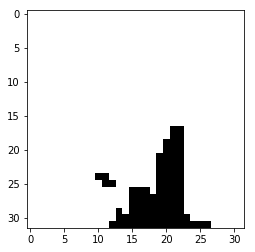

In [12]:
filenames = os.listdir(PATH+'resized/')

test_images = np.array([sk.io.imread(PATH+'resized/' + filenames[i]) for i in range(2)])

test_images = np.array([sk.transform.resize(image, IMAGE_SIZE) for image in test_images])

masks_o, landmarks = model.predict(test_images)
masks = (masks_o > 0.8).astype(np.uint8)

print(masks[0].shape)
for i in range(2):
    mask = np.squeeze(masks[i]).astype(np.float32)
    plt.imshow(np.dstack((mask,mask,mask)))
    
plt.show()